<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/Bama_20x20x10_GAF_and_MTF_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Getting Data from GitHub
!wget --no-check-certificate \
    https://github.com/omidmno2/stockMarketPrediction_DL/raw/main/tse_en.csv \
    -o /tmp/tse_en.csv

In [3]:
# Import required libraries
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [91]:
# Select the desired symbol
df = pd.read_csv("tse_en.csv")
df[df.Symbol == "كاما"].head()

,Date,Symbol,Name,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
1,2008-12-06,كاما,باما,2580,2657,2657,2605,25,2656.0,2657.0,14,21000,55793000
91,2008-12-07,كاما,باما,2605,2683,2565,2641,36,2565.0,2683.0,18,35139,93799687
271,2008-12-08,كاما,باما,2641,2571,2591,2596,-45,2569.0,2621.0,25,42835,110269609
356,2008-12-10,كاما,باما,2596,2571,2565,2586,-10,2519.0,2571.0,7,10557,26763973
467,2008-12-13,كاما,باما,2586,2509,2557,2573,-13,2509.0,2557.0,8,20845,53055381


In [92]:
# Data cleaning
bama = df[df.Symbol == "كاما"]
bama.index = pd.to_datetime(bama['Date'])
bama = bama.drop(columns=['Symbol', 'Name', 'Date']).dropna()
bama = bama.head(2450)

In [93]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

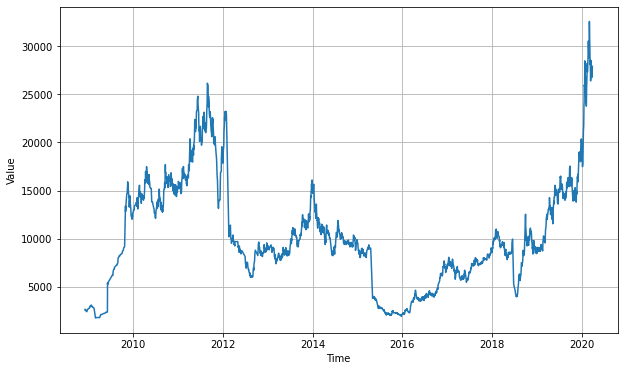

In [94]:
# Data plotting
series = np.array(bama["Last"])
time = np.array(bama.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [95]:
# Install pyts library for use Gramian Angular Field(GAF) and Markov Transition Field(MTF) method to create 2D pictures
!pip install pyts

In [96]:
from pyts.image import GramianAngularField, MarkovTransitionField
#https://johannfaouzi.github.io/pyts/index.html

In [97]:
bama.head(3)

,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
Date,,,,,,,,,,
2008-12-06,2580,2657,2657,2605,25,2656.0,2657.0,14,21000,55793000
2008-12-07,2605,2683,2565,2641,36,2565.0,2683.0,18,35139,93799687
2008-12-08,2641,2571,2591,2596,-45,2569.0,2621.0,25,42835,110269609


In [98]:
# GAF transformations
image_size = 20
window_size = 60

gaf = GramianAngularField(image_size)
windows_gaf = []
for i in range(len(bama.Last) - window_size):
    #window = np.array(bama.Last[i:i + window_size]).reshape(1, -1)
    window = bama[i:i + window_size].transpose()
    window_gaf = gaf.fit_transform(window)
    #windows_gaf.append(window_gaf[0])
    windows_gaf.append(window_gaf.reshape(20, 20, 10))

In [99]:
windows_gaf[0].shape

(20, 20, 10)

In [100]:
# MTF transformation
image_size = 20
window_size = 60

mtf = MarkovTransitionField(image_size)
windows_mtf = []
for i in range(len(bama) - window_size):
    #window = np.array(bama.Last[i:i + window_size]).reshape(1, -1)
    window = bama[i:i + window_size].transpose()
    window_mtf = mtf.fit_transform(window)
    #windows_mtf.append(window_mtf[0])
    windows_mtf.append(window_mtf.reshape(20, 20, 10))

/usr/local/lib/python3.7/dist-packages/pyts/preprocessing/discretizer.py:171: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [2]. Consider decreasing the number of bins or removing these samples.
  .format(samples))
/usr/local/lib/python3.7/dist-packages/pyts/preprocessing/discretizer.py:171: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  .format(samples))
/usr/local/lib/python3.7/dist-packages/pyts/preprocessing/discretizer.py:171: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  .format(samples))
/usr/local/lib/python3.7/dist-packages/pyts/preprocessing/discretizer.py:171: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0 2]. Consider decreasing the number of bins or removing these samples.
  

In [101]:
windows_mtf[0].shape

(20, 20, 10)

In [102]:
len(windows_gaf)

2390

In [103]:
len(bama.Last[60:])

2390

In [104]:
# Algorithm 1
# Labeling (Buy, Sell, Hold)

window_size = 11
counter = 0
bsh_labels = []

window_begin_idx=0
window_end_idx=0
window_middle_idx=0

min_idx=0
max_idx=0
number=0.0
mins=10000.0
maxs=0.0
while counter < len(bama.Last):
    if counter > window_size:
        window_begin_idx = counter - window_size
        window_end_idx = window_begin_idx + window_size - 1
        window_middle_idx = (window_begin_idx + window_end_idx)//2
        for i in range(window_begin_idx, window_end_idx+1):
            number = bama.Last[i]
            if number < mins:
                mins=number
                min_idx = np.where(bama.Last==mins)[0][0]
            if number > maxs:
                maxs=number
                max_idx = np.where(bama.Last==maxs)[0][0]
        if max_idx == window_middle_idx:
            bsh_labels.append(0) #SELL
        elif min_idx == window_middle_idx:
            bsh_labels.append(1) #BUY
        else:
            bsh_labels.append(2) #HOLD  
        mins = 10000.0
        maxs = 0.0
    counter+=1

In [105]:
len(bsh_labels)

2438

In [106]:
len(bama.Last)

2450

In [107]:
len(bama.Last) - len(bsh_labels)
# You should remove 6 rows from head and 6 rows from tail of data or actualy pictures.
# After checking, it was found that this difference is due to the fact that 6 lines from the top and 6 lines from the bottom have been removed.
# شش تای اول و شش تای آخر حذف میشوند موقع درست کردن لیبل

12

In [108]:
bsh_labels = bsh_labels[54:]
windows_gaf = windows_gaf[:-6]
windows_mtf = windows_mtf[:-6]
print(len(bsh_labels))
print(len(windows_gaf))
print(len(windows_mtf))

2384
2384
2384


In [109]:
# Divide the data into training and validation data for GAF
split_time = 2000
y_train = bsh_labels[:split_time]
x_train = windows_gaf[:split_time]
y_valid = bsh_labels[split_time:]
x_valid = windows_gaf[split_time:]

y_train = np.array(y_train)
x_train = np.array(x_train)
y_valid = np.array(y_valid)
x_valid = np.array(x_valid)

y_train = tf.keras.utils.to_categorical(y_train, 3)
y_valid = tf.keras.utils.to_categorical(y_valid, 3)

In [110]:
# Create and train the model for GAF
import tensorflow as tf

model = tf.keras.models.Sequential([
    #tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 10)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 18, 18, 32)        2912      
                                                                 
 conv2d_45 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_46 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_47 (Conv2D)          (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 6, 6, 128)         0         
                                                     

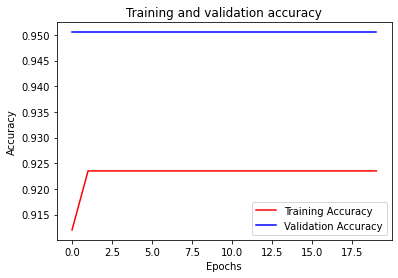

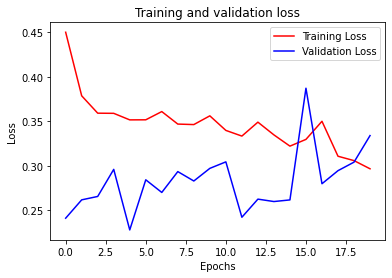

In [111]:
# Ploting accuracy and loss diagrams for GAF
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure().add_subplot(xlabel='Epochs', ylabel='Accuracy')
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure().add_subplot(xlabel='Epochs', ylabel='Loss')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [112]:
# Divide the data into training and validation data for MTF
split_time = 2000
y_train = bsh_labels[:split_time]
x_train = windows_mtf[:split_time]
y_valid = bsh_labels[split_time:]
x_valid = windows_mtf[split_time:]

y_train = np.array(y_train)
x_train = np.array(x_train)
y_valid = np.array(y_valid)
x_valid = np.array(x_valid)

y_train = tf.keras.utils.to_categorical(y_train, 3)
y_valid = tf.keras.utils.to_categorical(y_valid, 3)

In [113]:
# Create and train the model for MTF
import tensorflow as tf

model = tf.keras.models.Sequential([
    #tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 10)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 18, 18, 32)        2912      
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_50 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_51 (Conv2D)          (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 6, 6, 128)         0         
                                                     

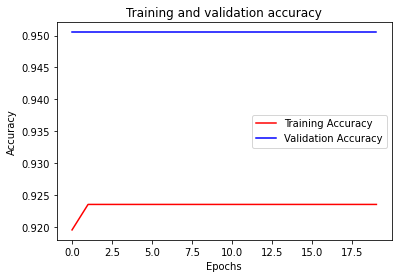

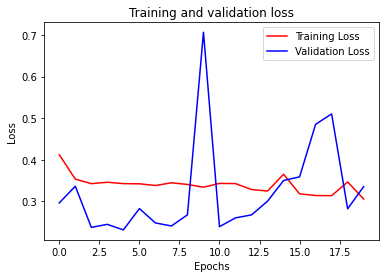

In [114]:
# Ploting accuracy and loss diagrams for MTF
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure().add_subplot(xlabel='Epochs', ylabel='Accuracy')
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure().add_subplot(xlabel='Epochs', ylabel='Loss')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [115]:
# Test Up and Down labeling method
bama.head()

,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
Date,,,,,,,,,,
2008-12-06,2580,2657,2657,2605,25,2656.0,2657.0,14,21000,55793000
2008-12-07,2605,2683,2565,2641,36,2565.0,2683.0,18,35139,93799687
2008-12-08,2641,2571,2591,2596,-45,2569.0,2621.0,25,42835,110269609
2008-12-10,2596,2571,2565,2586,-10,2519.0,2571.0,7,10557,26763973
2008-12-13,2586,2509,2557,2573,-13,2509.0,2557.0,8,20845,53055381


In [116]:
# labeling Up or Down

ud_labels = []

for i in range(1, len(bama.Last)):
    if bama.Last[i] < bama.Last[i-1]:
        ud_labels.append(0) # 0 = Down
    else:
        ud_labels.append(1) # 1 = Up
        
# This method miss first row from data, you should remove first row then train it

ud_labels = ud_labels[59:-6]
len(ud_labels)

2384

In [117]:
len(windows_gaf)

2384

In [118]:
# Divide the data into training and validation data for GAF
split_time = 2000
y_train = ud_labels[:split_time]
x_train = windows_gaf[:split_time]
y_valid = ud_labels[split_time:]
x_valid = windows_gaf[split_time:]

y_train = np.array(y_train)
x_train = np.array(x_train)
y_valid = np.array(y_valid)
x_valid = np.array(x_valid)

#y_train = tf.keras.utils.to_categorical(y_train, 2)
#y_valid = tf.keras.utils.to_categorical(y_valid, 2)

In [119]:
# Create and train the model for GAF
import tensorflow as tf

model = tf.keras.models.Sequential([
    #tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 10)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='softmax')
])

model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=1)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 18, 18, 32)        2912      
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_54 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_55 (Conv2D)          (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 6, 6, 128)         0         
                                                     

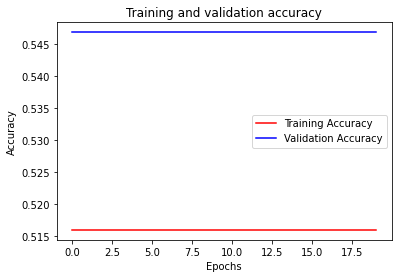

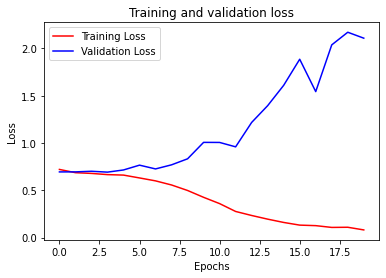

In [120]:
# Ploting accuracy and loss diagrams for GAF
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure().add_subplot(xlabel='Epochs', ylabel='Accuracy')
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure().add_subplot(xlabel='Epochs', ylabel='Loss')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [121]:
# Divide the data into training and validation data for MTF
split_time = 2000
y_train = ud_labels[:split_time]
x_train = windows_mtf[:split_time]
y_valid = ud_labels[split_time:]
x_valid = windows_mtf[split_time:]

y_train = np.array(y_train)
x_train = np.array(x_train)
y_valid = np.array(y_valid)
x_valid = np.array(x_valid)

#y_train = tf.keras.utils.to_categorical(y_train, 2)
#y_valid = tf.keras.utils.to_categorical(y_valid, 2)

In [122]:
# Create and train the model for MTF
import tensorflow as tf

model = tf.keras.models.Sequential([
    #tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 20, 10)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='softmax')
])

model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=1)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 18, 18, 32)        2912      
                                                                 
 conv2d_57 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_58 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_59 (Conv2D)          (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 6, 6, 128)         0         
                                                     

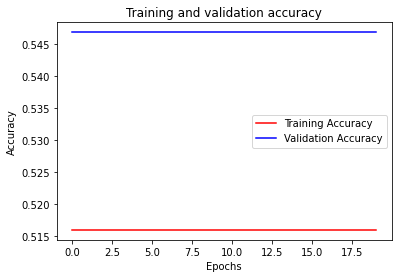

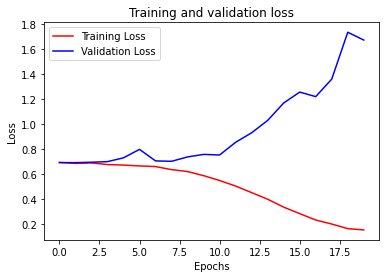

In [123]:
# Ploting accuracy and loss diagrams for MTF
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure().add_subplot(xlabel='Epochs', ylabel='Accuracy')
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure().add_subplot(xlabel='Epochs', ylabel='Loss')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()